# Example Notebook for the SimpleGenericGenerator Implementation

This example notebook demonstrates how to use the `SimpleGenericGenerator` class to generate item-response curves for a given input image, perturber, and scorer metric.

## Table of Contents
* [Set Up the Environment](#environment-setup)
* [Select Sample Input Image and Detections](#sample-input-image-and-detection)
* [Initialize Pipeline Instances](#initialize-pipeline-instances)
* [Generate and Visualize Item-Response Curves](#generate-and-visualize-item-response-curves)

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/nrtk/blob/main/docs/examples/simple_generic_generator.ipynb)

## Set Up the Environment <a name="environment-setup"></a>

**Note for Colab users**: After setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](./README.md) for more info).

Note: We are suppressing warnings within this notebook to reduce visual clutter for demonstration purposes. If any issues arise while executing this notebook, we recommend that this cell is **not** executed so that any related warnings are shown. 

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
import sys  # noqa: F401

!{sys.executable} -m pip install -qU pip
print("Installing nrtk...")
!{sys.executable} -m pip install -q nrtk
print("Installing torch and torchvision...")
!{sys.executable} -m pip install -q "torch!=2.0.1" torchvision
print("Installing headless OpenCV...")
!{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!{sys.executable} -m pip install -q opencv-python-headless
print("Done!")

Installing nrtk...
Installing torch and torchvision...
Done!


## Select Sample Input Image and Detections <a name="sample-input-image-and-detection"></a>

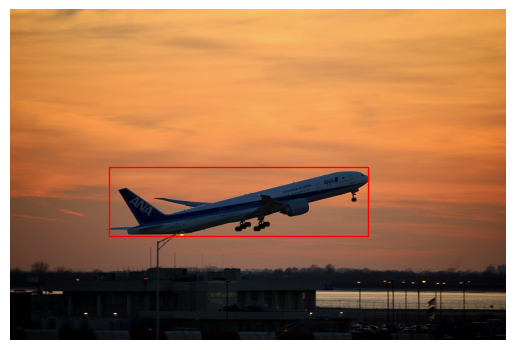

In [2]:
import os
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from PIL import Image
from smqtk_image_io.bbox import AxisAlignedBoundingBox

data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

url = "https://data.kitware.com/api/v1/item/6596fde79c30d6f4e17c9ef9/download"

img_path = os.path.join(data_dir, "example.jpg")
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve(url, img_path)  # noqa: S310
img = np.asarray(Image.open(img_path))

conf_dict = dict()
conf_dict[1] = 1.0
gt = [[(AxisAlignedBoundingBox([255, 406], [924, 583]), conf_dict)]]
bbox = gt[0][0][0]
width = bbox.max_vertex[0] - bbox.min_vertex[0]
height = bbox.max_vertex[1] - bbox.min_vertex[1]

fig, ax = plt.subplots()
ax.imshow(img)
ax.set_axis_off()
ax.add_patch(
    Rectangle(
        (bbox.min_vertex[0], bbox.min_vertex[1]),
        width,
        height,
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    ),
)
plt.show()

## Initialize Pipeline Instances <a name="initialize-pipeline-instances"></a>

In the cell below, we initialize the model, perturber, perturber factory, generator, and the scorer instances needed for our pipeline.

In [3]:
from smqtk_detection.impls.detect_image_objects.resnet_frcnn import ResNetFRCNN

from nrtk.impls.gen_object_detector_blackbox_response.simple_generic_generator import SimpleGenericGenerator
from nrtk.impls.perturb_image.generic.cv2.blur import GaussianBlurPerturber
from nrtk.impls.perturb_image_factory.generic.step import StepPerturbImageFactory
from nrtk.impls.score_detections.class_agnostic_pixelwise_iou_scorer import ClassAgnosticPixelwiseIoUScorer

img_batch_size = 1

perturber_factory = StepPerturbImageFactory(
    perturber=GaussianBlurPerturber,
    theta_key="ksize",
    start=1,
    stop=151,
    step=2,
)

detector = ResNetFRCNN(use_cuda=False, num_dets=1)
detector.get_model()

scorer = ClassAgnosticPixelwiseIoUScorer()

generator = SimpleGenericGenerator(images=[img], ground_truth=gt)

## Generate and Visualize Item-Response Curves <a name="generate-and-visualize-item-response-curves"></a>

Using the initialized pipeline instances from above, we generate and visualize the item-response curves (IRC) to see how the `ClassAgnosticPixelwiseIoU` scores are impacted when applying the `GaussianBlurPerturber` on the input image.

  0%|          | 0/75 [00:00<?, ?it/s]

100%|██████████| 75/75 [02:05<00:00,  1.68s/it]


Text(0, 0.5, 'mean ClassAgnosticPixelwiseIoU')

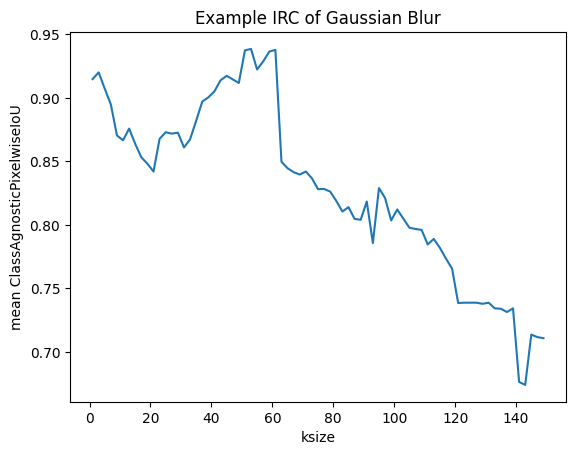

In [4]:
import random

import torch

random.seed(42)
np.random.seed(42)  # noqa: NPY002
torch.manual_seed(42)

curve, full = generator(
    blackbox_perturber_factories=[perturber_factory],
    blackbox_detector=detector,
    blackbox_scorer=scorer,
    img_batch_size=img_batch_size,
    verbose=True,
)

x = list()
y = list()
for data in curve:
    x.append(data[0]["ksize"])
    y.append(data[1])

plt.cla()
plt.plot(x, y)
plt.title("Example IRC of Gaussian Blur")
plt.xlabel("ksize")
plt.ylabel("mean ClassAgnosticPixelwiseIoU")